In [444]:
N_ALLOWED_CARS = 20
N_ALLOWED_CUSTOMERS = 20
N_ALLOWED_RETURNS = 20

#ALLOWED_MOVES = [-3, -2, -1, 0, 1, 2, 3]
ALLOWED_MOVES = [-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5]
MAX_MOVE = maximum(ALLOWED_MOVES)

DISCOUNT = 0.9

0.9

In [445]:
function log_poisson(x::Integer, λ::Real)
    if x == 0
        return -λ
    else
        return -λ + x*log(λ) - sum(log(k) for k in 1:x)
    end
end

function poisson(x::Real, λ::Real)
    return exp(log_poisson(x, λ))
end

poisson (generic function with 1 method)

In [446]:
function make_poisson_array(n::Integer, λ::Real)
    p = zeros(N_ALLOWED_CARS + 1)
    for x in 0:(N_ALLOWED_CARS - 1)
        p[x + 1] = poisson(x, λ)
    end
    p[N_ALLOWED_CARS + 1] = 1 - sum(p)
    return p
end

make_poisson_array (generic function with 1 method)

In [447]:
POISSON2 = make_poisson_array(N_ALLOWED_CARS, 2)
POISSON3 = make_poisson_array(N_ALLOWED_CARS, 3)
POISSON4 = make_poisson_array(N_ALLOWED_CARS, 4)

21-element Array{Float64,1}:
 0.01831563888873418
 0.07326255555493673
 0.14652511110987343
 0.19536681481316454
 0.19536681481316462
 0.1562934518505317
 0.10419563456702102
 0.0595403626097263
 0.029770181304863145
 0.013231191691050281
 0.005292476676420107
 0.001924536973243679
 0.0006415123244145577
 0.00019738840751217174
 5.6396687860620494e-5
 1.5039116762832128e-5
 3.759779190708031e-6
 8.8465392722542e-7
 1.965897616056495e-7
 4.1387318232768255e-8
 1.020052231570645e-8

## Policy Evaluation

In [449]:
function update_values(
        policy::Array{Int64, 2}, 
        values::Array{Float64, 2},
        N_ALLOWED_CARS::Int64 = N_ALLOWED_CARS,
        N_ALLOWED_CUSTOMERS::Int64 = N_ALLOWED_CUSTOMERS,
        N_ALLOWED_RETURNS::Int64 = N_ALLOWED_RETURNS,
        POISSON2::Array{Float64, 1} = POISSON2,
        POISSON3::Array{Float64, 1} = POISSON3,
        POISSON4::Array{Float64, 1} = POISSON4,
        DISCOUNT::Float64 = DISCOUNT   
)
    V = zeros(Float64, N_ALLOWED_CARS + 1, N_ALLOWED_CARS + 1)
    for x1 in 0:N_ALLOWED_CARS, x2 in 0:N_ALLOWED_CARS
        for c1 in 0:N_ALLOWED_CUSTOMERS, c2 in 0:N_ALLOWED_CUSTOMERS
            for r1 in 0:N_ALLOWED_RETURNS, r2 in 0:N_ALLOWED_RETURNS
                # The sequence of events is:
                #   -> Move cars action
                action = policy[x1 + 1, x2 + 1]
                #   -> Begining of day (y1, y2)
                y1 = clamp(x1 - action, 0, N_ALLOWED_CARS)
                y2 = clamp(x2 + action, 0, N_ALLOWED_CARS)
                #   -> Rent to customers (rented1, rented2)
                rented1, rented2 = min(y1, c1), min(y2, c2)
                # -> Calculate reward
                reward = 10 * rented1 + 10 * rented2 - 2 * abs(action)
                # Process returns to get to new state.
                z1 = min(y1 - rented1 + r1, N_ALLOWED_CARS) 
                z2 = min(y2 - rented2 + r2, N_ALLOWED_CARS)  
                # Update the value function by discounting the value of the new state.
                V[x1 + 1, x2 + 1] += (
                    POISSON3[c1 + 1] * POISSON4[c2 + 1] * POISSON3[r1 + 1] * POISSON2[r2 + 1]
                    * (reward + DISCOUNT * values[z1 + 1, z2 + 1])
                )
            end
        end
    end
    return V
end

function policy_evaluation(
        policy::Array{Int64, 2},
        N_ALLOWED_CARS::Int64 = N_ALLOWED_CARS
)
    values = zeros(Float64, N_ALLOWED_CARS + 1, N_ALLOWED_CARS + 1)
    while true
        # display(values)
        old_values = copy(values)
        values = update_values(policy, old_values)
        if isapprox(values, old_values, atol=10.0)
            break
        end
    end
    return values
end

policy_evaluation (generic function with 4 methods)

## Policy Improvement

In [450]:
function update_policy(
        values::Array{Float64, 2},
        N_ALLOWED_CARS::Int64 = N_ALLOWED_CARS,
        N_ALLOWED_CUSTOMERS::Int64 = N_ALLOWED_CUSTOMERS,
        N_ALLOWED_RETURNS::Int64 = N_ALLOWED_RETURNS,
        POISSON2::Array{Float64, 1} = POISSON2,
        POISSON3::Array{Float64, 1} = POISSON3,
        POISSON4::Array{Float64, 1} = POISSON4,
        DISCOUNT::Float64 = DISCOUNT   
)
    Q = zeros(Float64, N_ALLOWED_CARS + 1, N_ALLOWED_CARS + 1, length(ALLOWED_MOVES))
    for x1 in 0:N_ALLOWED_CARS, x2 in 0:N_ALLOWED_CARS
        for c1 in 0:N_ALLOWED_CUSTOMERS, c2 in 0:N_ALLOWED_CUSTOMERS
            for r1 in 0:N_ALLOWED_RETURNS, r2 in 0:N_ALLOWED_RETURNS
                for action in ALLOWED_MOVES
                    # End of day (x1, x1)
                    #   -> Move cars action
                    # Cannot move more cars than are available.
                    if action > x1 || -action > x2
                        continue 
                    end
                    #   -> Begining of day (y1, y2)
                    y1 = clamp(x1 - action, 0, N_ALLOWED_CARS)
                    y2 = clamp(x2 + action, 0, N_ALLOWED_CARS)
                    #   -> Rent to customers (rented1, rented2)
                    rented1, rented2 = min(y1, c1), min(y2, c2)
                    # -> Calculate reward
                    reward = 10 * rented1 + 10 * rented2 - 2 * abs(action)
                    # Process returns to get to new state.
                    z1 = min(y1 - rented1 + r1, N_ALLOWED_CARS) 
                    z2 = min(y2 - rented2 + r2, N_ALLOWED_CARS)                      
                    # Update the action-value function.
                    Q[x1 + 1, x2 + 1, action + MAX_MOVE + 1] += (
                       POISSON3[c1 + 1] * POISSON4[c2 + 1] * POISSON3[r1 + 1] * POISSON2[r2 + 1]
                       * (reward + DISCOUNT * values[z1 + 1, z2 + 1])
                    )
                end
            end
        end
    end
    # Argmax over the final dimenison of Q (the action index) to calculate the new optimal action.
    Qidx = Int64[x[3] for x in argmax(Q, dims=3)[:, :, 1]]
    return Int64[ALLOWED_MOVES[x] for x in Qidx]
end

update_policy (generic function with 10 methods)

In [451]:
function learn_policy(N_ALLOWED_CARS::Int64 = N_ALLOWED_CARS)
    values = zeros(Float64, (N_ALLOWED_CARS + 1, N_ALLOWED_CARS + 1))
    policy = zeros(Int64, (N_ALLOWED_CARS + 1, N_ALLOWED_CARS + 1))
    while true
        display(policy)
        old_policy = copy(policy)
        values = policy_evaluation(policy)
        policy = update_policy(values)
        if old_policy == policy
            break
        end
    end
    return (policy, policy_evaluation(policy))
end

learn_policy (generic function with 2 methods)

In [452]:
policy, values = learn_policy()

21×21 Array{Int64,2}:
 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0 

21×21 Array{Int64,2}:
 0  0  0  0  0  0  0  0  -1  -1  -1  -2  -2  -2  -2  -3  -3  -3  -3  -3  -4
 0  0  0  0  0  0  0  0   0   0  -1  -1  -1  -1  -2  -2  -2  -2  -2  -3  -3
 0  0  0  0  0  0  0  0   0   0   0   0   0  -1  -1  -1  -1  -1  -2  -2  -2
 0  0  0  0  0  0  0  0   0   0   0   0   0   0   0   0   0  -1  -1  -1  -1
 1  1  1  1  0  0  0  0   0   0   0   0   0   0   0   0   0   0   0   0  -1
 2  2  2  1  1  1  1  0   0   0   0   0   0   0   0   0   0   0   0   0   0
 3  3  2  2  2  2  1  1   1   1   0   0   0   0   0   0   0   0   0   0   0
 4  3  3  3  3  2  2  2   2   1   1   1   0   0   0   0   0   0   0   0   0
 4  4  4  4  3  3  3  3   2   2   2   1   1   1   1   0   0   0   0   0   0
 5  5  5  4  4  4  4  3   3   3   2   2   2   2   1   1   1   0   0   0   0
 5  5  5  5  5  5  4  4   4   3   3   3   3   2   2   2   1   1   0   0   0
 5  5  5  5  5  5  5  5   4   4   4   4   3   3   3   2   2   1   1   0   0
 5  5  5  5  5  5  5  5   5   5   5   4   4   4   3   3   2   2   

21×21 Array{Int64,2}:
 0  0  0  0  0  0  0  -1  -1  -1  -2  -2  -2  -3  -3  -3  -3  -3  -3  -4  -4
 0  0  0  0  0  0  0   0   0  -1  -1  -1  -2  -2  -2  -2  -2  -2  -3  -3  -3
 0  0  0  0  0  0  0   0   0   0   0  -1  -1  -1  -1  -1  -1  -2  -2  -2  -2
 0  0  0  0  0  0  0   0   0   0   0   0   0   0   0   0  -1  -1  -1  -1  -1
 1  0  0  0  0  0  0   0   0   0   0   0   0   0   0   0   0   0   0   0  -1
 1  1  1  0  0  0  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
 2  2  1  1  1  0  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
 3  2  2  2  1  0  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
 3  3  3  2  1  1  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
 4  4  3  2  2  1  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
 5  4  3  3  2  1  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
 5  4  4  3  2  1  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
 5  5  4  3  2  1  0   0   0   0   0   0   0   0   0  

21×21 Array{Int64,2}:
 0  0  0  0  0  0  0  0  -1  -1  -2  -2  -2  -3  -3  -3  -3  -3  -4  -4  -4
 0  0  0  0  0  0  0  0   0  -1  -1  -1  -2  -2  -2  -2  -2  -3  -3  -3  -3
 0  0  0  0  0  0  0  0   0   0   0  -1  -1  -1  -1  -1  -2  -2  -2  -2  -2
 0  0  0  0  0  0  0  0   0   0   0   0   0   0   0  -1  -1  -1  -1  -1  -2
 0  0  0  0  0  0  0  0   0   0   0   0   0   0   0   0   0   0   0  -1  -1
 1  1  1  0  0  0  0  0   0   0   0   0   0   0   0   0   0   0   0   0   0
 2  2  1  1  0  0  0  0   0   0   0   0   0   0   0   0   0   0   0   0   0
 3  2  2  1  1  0  0  0   0   0   0   0   0   0   0   0   0   0   0   0   0
 3  3  2  2  1  1  0  0   0   0   0   0   0   0   0   0   0   0   0   0   0
 4  3  3  2  2  1  0  0   0   0   0   0   0   0   0   0   0   0   0   0   0
 4  4  3  3  2  1  0  0   0   0   0   0   0   0   0   0   0   0   0   0   0
 5  4  4  3  2  1  1  0   0   0   0   0   0   0   0   0   0   0   0   0   0
 5  5  4  3  2  2  1  0   0   0   0   0   0   0   0   0   0   0   

21×21 Array{Int64,2}:
 0  0  0  0  0  0  0  0  -1  -1  -2  -2  -2  -3  -3  -3  -3  -3  -4  -4  -4
 0  0  0  0  0  0  0  0   0  -1  -1  -1  -2  -2  -2  -2  -2  -3  -3  -3  -3
 0  0  0  0  0  0  0  0   0   0   0  -1  -1  -1  -1  -1  -2  -2  -2  -2  -2
 0  0  0  0  0  0  0  0   0   0   0   0   0   0   0  -1  -1  -1  -1  -1  -2
 0  0  0  0  0  0  0  0   0   0   0   0   0   0   0   0   0   0   0  -1  -1
 1  1  1  0  0  0  0  0   0   0   0   0   0   0   0   0   0   0   0   0   0
 2  2  1  1  0  0  0  0   0   0   0   0   0   0   0   0   0   0   0   0   0
 3  2  2  1  1  0  0  0   0   0   0   0   0   0   0   0   0   0   0   0   0
 3  3  2  2  1  1  0  0   0   0   0   0   0   0   0   0   0   0   0   0   0
 4  3  3  2  2  1  0  0   0   0   0   0   0   0   0   0   0   0   0   0   0
 4  4  3  3  2  1  0  0   0   0   0   0   0   0   0   0   0   0   0   0   0
 5  4  4  3  2  1  1  0   0   0   0   0   0   0   0   0   0   0   0   0   0
 5  5  4  3  2  2  1  0   0   0   0   0   0   0   0   0   0   0   

([0 0 … -4 -4; 0 0 … -3 -3; … ; 5 5 … 0 0; 5 5 … 0 0], [417.14968610536937 427.1219067541214 … 558.5492739930515 563.5041069407786; 427.0234342920885 436.9955887313214 … 565.5041069407814 570.1969703429011; … ; 546.5570460925259 553.3269915670567 … 629.7587854090324 632.0419257036916; 550.6833064448371 557.2947316454131 … 630.4887686185269 632.7249238960108])

In [453]:
display(policy)

21×21 Array{Int64,2}:
 0  0  0  0  0  0  0  0  -1  -1  -2  -2  -2  -3  -3  -3  -3  -3  -4  -4  -4
 0  0  0  0  0  0  0  0   0  -1  -1  -1  -2  -2  -2  -2  -2  -3  -3  -3  -3
 0  0  0  0  0  0  0  0   0   0   0  -1  -1  -1  -1  -1  -2  -2  -2  -2  -2
 0  0  0  0  0  0  0  0   0   0   0   0   0   0   0  -1  -1  -1  -1  -1  -2
 0  0  0  0  0  0  0  0   0   0   0   0   0   0   0   0   0   0   0  -1  -1
 1  1  1  0  0  0  0  0   0   0   0   0   0   0   0   0   0   0   0   0   0
 2  2  1  1  0  0  0  0   0   0   0   0   0   0   0   0   0   0   0   0   0
 3  2  2  1  1  0  0  0   0   0   0   0   0   0   0   0   0   0   0   0   0
 3  3  2  2  1  1  0  0   0   0   0   0   0   0   0   0   0   0   0   0   0
 4  3  3  2  2  1  0  0   0   0   0   0   0   0   0   0   0   0   0   0   0
 4  4  3  3  2  1  0  0   0   0   0   0   0   0   0   0   0   0   0   0   0
 5  4  4  3  2  1  1  0   0   0   0   0   0   0   0   0   0   0   0   0   0
 5  5  4  3  2  2  1  0   0   0   0   0   0   0   0   0   0   0   

In [454]:
display(values)

21×21 Array{Float64,2}:
 417.15   427.122  436.978  446.583  …  547.916  553.341  558.549  563.504
 427.023  436.996  446.851  456.455     555.341  560.549  565.504  570.197
 436.497  446.469  456.323  465.923     562.549  567.504  572.197  576.593
 445.32   455.291  465.141  474.732     569.504  574.197  578.593  582.706
 453.411  463.38   473.223  482.796     576.197  580.593  584.706  588.628
 461.38   471.223  480.796  490.186  …  582.413  586.706  590.628  594.07
 469.223  478.796  488.186  497.312     587.845  592.031  595.847  599.188
 476.796  486.186  495.312  504.099     592.655  596.736  600.449  603.694
 484.186  493.312  502.099  510.65      596.963  600.941  604.556  607.71
 491.312  500.099  508.65   516.896     600.855  604.731  608.25   611.318
 498.099  506.65   514.896  522.815  …  604.393  608.166  611.591  614.575
 504.65   512.896  520.815  528.553     607.625  611.293  614.623  617.523
 510.896  518.815  526.553  533.978     610.583  614.146  617.379  620.196
 51

In [458]:
using Plots

┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1260


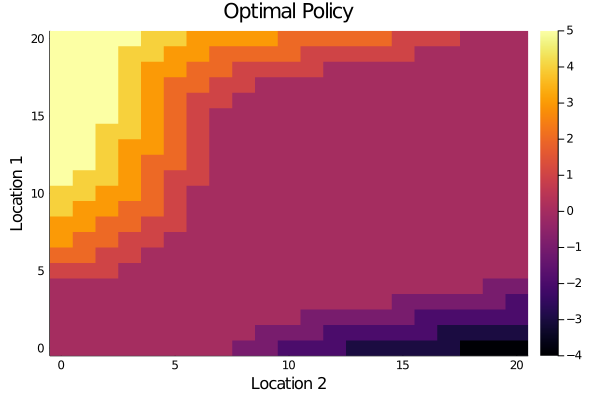

In [468]:
using Plots

p = heatmap(0:20, 0:20, policy)
title!(p, "Optimal Policy")
xlabel!(p, "Location 2")
ylabel!(p, "Location 1")

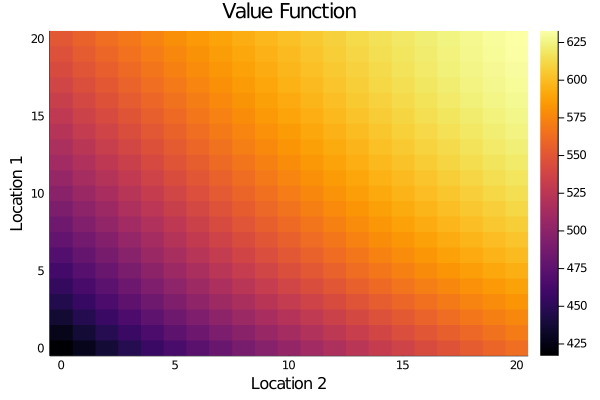

In [467]:
p = heatmap(0:20, 0:20, values)
title!(p, "Value Function")
xlabel!(p, "Location 2")
ylabel!(p, "Location 1")